# 🧠 **How I Created A Robust Credit Rating System For A Utility Company (Using Machine Learning)**

*This article is **Part 2** of a 3-Part Series on Customer Behavioral Risk Modelling and Monitoring. In Part 1, we created a simulated utility billing system and generated a dataset that resembles real-world customer billing and payment behavior. In this article, we use that behavioral history to train a predictive model that classifies risk before accounts become delinquent.*

## **1. Introduction**

### **Motivation: Predicting Risk Before It Becomes Loss**

In utility operations, financial losses rarely happen overnight. More often, they follow a pattern—subtle at first, then progressively clearer: missed payments, rising penalties, suspended services, and finally, write-offs. While working as a Data Analyst at Manitoba Hydro, I saw that the key to mitigating these losses wasn’t just detecting delinquency—it was predicting it early enough to act.

That insight inspired this three-part project series. Together, the articles walk through how I built a full-cycle solution to simulate, score, and surface customer credit risk:

- ✅ **Part 1: Data Simulation** – Created a simulated utility billing system and dataset that mimics real-world customer billing and payment behavior  
- 🔄 **Part 2: Machine Learning Classification** – (This article) Built a model that classifies account risk based on behavioral patterns  
- 🔄 **Part 3: Power BI Dashboard** – Visualized risk in a practical, explainable report for operations teams

Each phase builds on the last. In Part 1, we modeled the lifecycle of over 13,000 synthetic accounts—including usage, payments, penalties, suspensions, and closures—using a rule-based engine that captures how risk emerges over time.

This article, Part 2, shows how we used that behavioral history to train a machine learning model that flags accounts likely to default before they actually do.

### **What This Article Covers**

We’ll walk through the full journey of building a behavior-first risk classification model—starting with simulated billing data and ending with explainable predictions. Here’s what you’ll find:

- **Section 2: Dataset Foundation**  
  Recaps the simulated dataset from Part 1, focusing on how rule-based billing behavior sets the stage for machine learning.

- **Section 3: Feature Engineering**  
  Shows how we transformed raw billing snapshots into behavioral features—capturing trends like delinquency frequency, penalty accumulation, and recovery patterns.

- **Section 4: Labeling Strategy**  
  Defines our three-tier (A–B–C) risk classes using both final outcomes and behavioral clustering—ensuring our model learns from meaningful risk signals.

- **Section 5: Modeling and Training**  
  Walks through how we selected snapshots for training, built a Random Forest model, and optimized for both accuracy and real-world usability.

- **Section 6: Model Evaluation**  
  Analyzes performance using confusion matrices, prediction confidence, and behavior-over-time trends.

- **Section 7: Explainability**  
  Breaks down how we used SHAP values and feature importance to explain predictions—bridging the gap between data science and business teams.

- **Section 8: Case Studies**  
  Walks through real examples of each risk class, showing how the model interprets behavior and flags concern early.

- **Section 9: Recap and Reflections**  
  Summarizes the pipeline and insights from this phase, and how it leads into the final dashboard solution in Part 3.

By the end, we’ll have a working risk model that doesn’t just sort accounts into categories—but tells a story about why each one matters, and sets the stage for the dashboard in Part 3.


## **2. The Dataset: Monthly Balance Snapshots**

In Part 1, we built a synthetic dataset that simulates six years of monthly billing behavior for 14,000 utility accounts. Each account follows a behavioral lifecycle driven by rule-based logic—meaning every missed payment, penalty, or account closure happens for a reason.

The billing system works by reviewing each account’s balance at the start of every cycle and applying penalty points for unpaid amounts. **Partial payments** add **0.5 points**, while **missed or severely delayed payments** add up to **2.0 points**. As delinquency points accumulate, accounts escalate automatically:

- **5.0 points → Suspended**
- **10.0 points → Closed**

The **Balance Snapshots** table captures the state of each account at the start of every billing cycle, including:

- 📉 **Delinquent Amount (Unpaid Balance) and Ratio** – Tracks how much of the current bill remains unpaid, expressed both as a raw amount and as a percentage of the total due.
- ⚠️ **Delinquency Type and Penalty** – Categorizes delinquency based on severity (Minor, Partial, Major, Full), determined by the unpaid ratio. Each type maps to a penalty score from **0.5 to 2.0**, which contributes to overall risk.
- 🚨 **Delinquency Score** – A cumulative index of financial strain, calculated as the sum of all penalty points since the last clean billing cycle. It reflects how prolonged or severe an account’s issues have been.
- 🔒 **Delinquency Status** – Indicates the operational state of the account: **None**, **Delinquent**, **Suspended**, or **Closed**, depending on delinquency score thresholds and payment recovery.


To build a predictive model, we needed to turn these monthly records into something more meaningful—features that describe trends, consistency, and deterioration over time. In the next section, we’ll walk through how we engineered those behavioral signals.


In [1]:
import os

# Add the parent directory to the system path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Import our own modules
import warnings


pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

RAW_DATA_DIR = "data/raw"
PROCESSED_DATA_DIR = "data/preprocessed"
MODEL_OUTPUT_DIR = "data/ml_output"

In [2]:
# Load raw data
accounts = pd.read_csv(os.path.join(RAW_DATA_DIR, "accounts.csv"), parse_dates=['start_date'],)
balance_snapshots = pd.read_csv(os.path.join(RAW_DATA_DIR, "balance_snapshots.csv"), parse_dates=['check_date'], keep_default_na=True)
bad_debts = pd.read_csv(os.path.join(RAW_DATA_DIR, "bad_debts.csv"), parse_dates=['closing_date'],)

balance_snapshots = accounts[['account_id', 'account_key']].merge(
    balance_snapshots,
    on='account_id',
    how='right',
).set_index('snapshot_id', drop=False)
# Basic dimensions
print("Accounts shape:", accounts.shape)
print("Balance Snapshots shape:", balance_snapshots.shape)
print("Bad Debts shape:", bad_debts.shape)
balance_snapshots.head()

OSError: [Errno 89] Operation canceled

**Sample Accounts: Patterns That Signal Risk**

The dataset contains a wide range of customer behaviors—some stable, others risky. Below are two illustrative examples:

-	**Case 1: Low-Intensity Delinquency – Low Risk of Default** - 
    This account shows occasional missed payments early on, but consistently recovers. Delinquency scores remain low and never breach escalation thresholds. The overall trajectory is stable.
-	**Case 2: High-Intensity Delinquency – High Risk of Default** - 
    This account exhibits frequent, prolonged delinquency with escalating penalty scores. The customer repeatedly misses payments, pushing the account toward suspension and eventual closure.


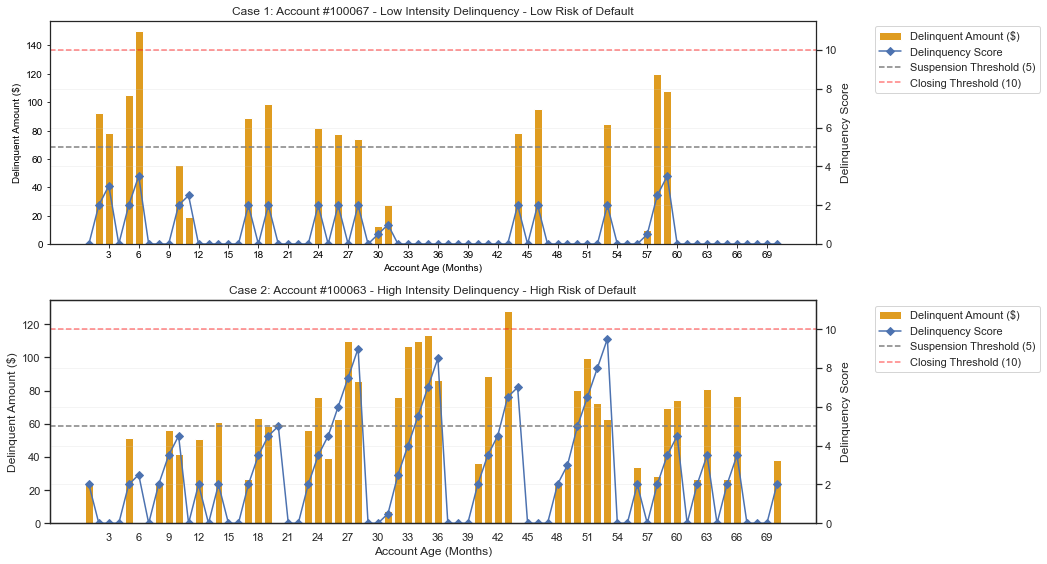

In [ ]:
# Sample an account without bad debt
def plot_account_snapshots_balance_and_delinquency(account_balance_snapshots):
    """
    Plots unpaid balance (bar) and delinquency score (line) for a single account.
    """
    sns.set_theme(style="white")
    ax1 = plt.gca()
    sns.barplot(
        data=account_balance_snapshots,
        x='account_age',
        y='unpaid_balance',
        color='orange',
        label='Delinquent Amount ($)',
        ax=ax1
    )
    ax1.set_ylabel('Delinquent Amount ($)')
    ax1.set_xlabel('Account Age (Months)')
    ax1.set_xticks(np.arange(2,len(account_balance_snapshots['account_age']) + 1, 3))
    ax1.set_ylim(0, None)
    ax1.legend().set_visible(False)

    ax2 = ax1.twinx()
    # Use plt.plot for the line to ensure alignment
    ax2.plot(
        account_balance_snapshots['account_age'] -1,  # Adjust x to match bar positions
        account_balance_snapshots['delinquency_score'],
        # color='blue',
        marker='D',
        label='Delinquency Score'
    )
    ax2.set_ylabel('Delinquency Score')
    ax2.set_ylim(0, 11.5)
    ax2.grid(axis='y', linestyle='-', alpha=0.2)
    ax2.axhline(y=5, color='grey', linestyle='--', label='Suspension Threshold (5)')
    ax2.axhline(y=10, color='red', linestyle='--', label='Closing Threshold (10)', alpha=0.5)

    account_id = account_balance_snapshots['account_id'].iloc[0]
    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right', bbox_to_anchor=(1.3, 1))

plt.figure(figsize=(15, 8))

account_key_1 = 100067 
selected_account_snapshots = balance_snapshots[balance_snapshots['account_key'] == account_key_1].sort_values(by="check_date", ascending=True)
selected_account_snapshots['account_age'] = range(1, len(selected_account_snapshots) + 1)
plt.subplot(2, 1, 1)
plot_account_snapshots_balance_and_delinquency(selected_account_snapshots)
plt.title(f"Case 1: Account #{account_key_1} - Low Intensity Delinquency - Low Risk of Default")

account_key_2 = 100063
selected_account_snapshots = balance_snapshots[balance_snapshots['account_key'] == account_key_2].sort_values(by="check_date", ascending=True)
selected_account_snapshots['account_age'] = range(1, len(selected_account_snapshots) + 1)
plt.subplot(2, 1, 2)
plot_account_snapshots_balance_and_delinquency(selected_account_snapshots)
plt.title(f"Case 2: Account #{account_key_2} - High Intensity Delinquency - High Risk of Default")

plt.tight_layout()
plt.show()



## **3. Feature Engineering: Quantifying Behavioral Risk**

### **Feature Engineering**

To translate each account’s timeline into structured, meaningful features, we engineered behavioral indicators that reflect how risk builds up over time.

For every modeling snapshot, we looked back at the account’s history and calculated trends such as:

- **Rate of Offense**: How often did the account miss, delay, or get suspended?  
- **Streak of Offenses**: Were there clusters of repeated misses or prolonged delinquency?  
- **Peak of Offense**: What was the highest delinquency score the account reached?  
- **Recent Trends**: How had the account been performing over the last 3, 6, and 12 months across key signals?

To ensure fairness across accounts at different stages of their lifecycle, we **normalized many of these features based on account age**.

### **Why We Exclude Dollar Amounts**

We also intentionally **excluded monetary values** from the training process to ensure the model focused on behavior—not just bill size or usage level. This helped create a model that generalizes across customer tiers and plan types.


Raw Features

In [ ]:
balance_snapshots_raw_features = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, "balance_snapshots_raw_features.csv"), parse_dates=['check_date']).set_index('snapshot_id', drop=False)
print("Balance Snapshots Raw Features shape:", balance_snapshots_raw_features.shape)
sample_indices = balance_snapshots_raw_features.sample(5, random_state=0).index
balance_snapshots_raw_features.loc[sample_indices]

Balance Snapshots Raw Features shape: (580129, 28)


,snapshot_id,account_id,check_date,check_cycle_number,is_delinquent,total_delinquencies,count_suspension,count_actively_delinquent,max_delinquency_score,total_penalties,average_penalty_per_incident,count_streak_1,count_streak_2_3,count_streak_4plus,count_full_misses,count_major_misses,count_partial_misses,count_minor_misses,total_delinquent_amount,average_delinquent_amount_per_incident,max_delinquent_amount,current_balance,current_delinquency_score,rolling_avg_delinquency_score_3m,rolling_avg_delinquency_score_6m,rolling_avg_penalty_3m,rolling_avg_penalty_6m,max_delinquency_score_12m
snapshot_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
216621,216621,520dd03f-ac14-4a9e-a960-caa0e8eff6e7,2021-05-25,16,False,9,0,9,4.5,15.5,1.722222,4,2,0,6,2,0,1,503.93,55.992222,90.37,0.0,0.0,0.666667,1.833333,0.666667,1.083333,4.5
281483,281483,67df0984-c249-4d0e-87b2-afa01698e8ef,2023-07-14,26,False,10,0,10,3.5,16.5,1.650000,6,2,0,7,1,0,2,1309.47,130.947000,243.91,0.0,0.0,0.666667,0.666667,0.666667,0.666667,3.5
50048,50048,f00e3a8d-1d8d-42e0-97b5-bb0896729d6f,2022-06-19,1,False,0,0,0,0.0,0.0,0.000000,0,0,0,0,0,0,0,0.00,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
313125,313125,2ae7d088-8c0c-4b19-a5cc-38e44ca79ddb,2024-05-09,52,False,27,2,25,7.5,43.0,1.592593,5,7,1,14,6,5,2,4157.64,153.986667,293.53,0.0,0.0,1.500000,2.000000,0.833333,0.666667,7.5
56279,56279,844e1cd1-4a00-4d17-a270-6a1858bf56be,2022-09-17,9,True,4,0,4,3.0,7.0,1.750000,2,1,0,3,0,1,0,892.91,223.227500,285.57,197.8,2.0,1.666667,1.166667,1.000000,0.833333,3.0


Final Features

In [6]:
balance_snapshots_features = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, "balance_snapshots_features.csv")).set_index('snapshot_id', drop=True)
print("Balance Snapshots Features shape:", balance_snapshots_features.shape)
balance_snapshots_features.loc[sample_indices]

Balance Snapshots Features shape: (580129, 14)


,check_cycle_number,max_delinquency_score,average_penalty_per_incident,total_delinquencies_norm,count_suspension_norm,count_actively_delinquent_norm,total_penalties_norm,count_streak_1_norm,count_streak_2_3_norm,count_streak_4plus_norm,count_full_misses_norm,count_major_misses_norm,count_partial_misses_norm,count_minor_misses_norm
snapshot_id,,,,,,,,,,,,,,
216621,16,4.5,1.722222,0.562500,0.000000,0.562500,0.968750,0.250000,0.125000,0.000000,0.375000,0.125000,0.000000,0.062500
281483,26,3.5,1.650000,0.384615,0.000000,0.384615,0.634615,0.230769,0.076923,0.000000,0.269231,0.038462,0.000000,0.076923
50048,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
313125,52,7.5,1.592593,0.519231,0.038462,0.480769,0.826923,0.096154,0.134615,0.019231,0.269231,0.115385,0.096154,0.038462
56279,9,3.0,1.750000,0.444444,0.000000,0.444444,0.777778,0.222222,0.111111,0.000000,0.333333,0.000000,0.111111,0.000000


In [ ]:
balance_snapshots.loc[sample_indices]

## **4. Labeling Policy: Defining What We Want to Predict**

With features in place, the next step was defining what we mean by *“risky.”*

### **Starting Point**

A simple binary classification—labeling closed accounts as high-risk—is a natural starting point, but it misses important nuance. Some accounts may show warning signs for months without formally closing, while others remain active but are clearly on a decline.

### **Final Solution**

To improve granularity, we defined a three-tier credit rating labeling system:

- **Class A (Low Risk):** Mature accounts (24+ months) with stable behavior—little to no delinquency, and consistent payment history over time.  
- **Class B (Medium Risk):** Mature accounts (24+ months) that have shown signs of repeated payment issues or penalty accumulation but have not escalated to closure.  
- **Class C (High Risk):** All accounts that were eventually closed due to delinquency, regardless of age, plus accounts that exhibited sustained risky behavior—such as prolonged suspension or escalating penalties.

This three-tier system balances interpretability with granularity. It allows us to:

- **Separate** clear extremes (A vs. C)  
- **Capture** the uncertainty and diversity of behavior in the middle  
- **Prioritize** monitoring and analysis for the medium-risk group, where interventions are most valuable


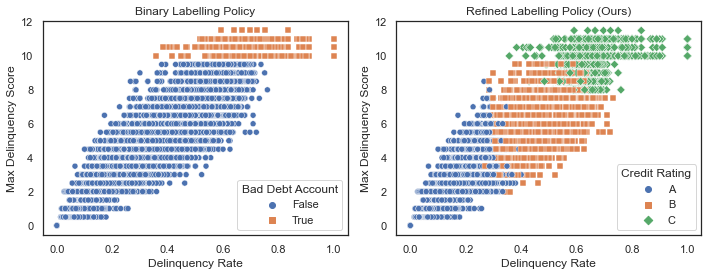

In [10]:
balance_snapshots_metadata = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, "balance_snapshots_metadata.csv")).set_index('snapshot_id', drop=False)
# balance_snapshots_metadata.loc[sample_indices,['snapshot_id', 'account_id', 'check_cycle_number', 'naiive_label', 'label', 'purpose']]

final_snapshots_features = balance_snapshots_features.loc[balance_snapshots_metadata['purpose'] == 'final_label']
final_snapshots_metadata = balance_snapshots_metadata.loc[balance_snapshots_metadata['purpose'] == 'final_label']
final_snapshots_combined = pd.concat([final_snapshots_features, final_snapshots_metadata], axis=1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=final_snapshots_features['total_delinquencies_norm'],
    y=final_snapshots_features['max_delinquency_score'],
    hue=final_snapshots_metadata['is_bad_debt_account'],
    style=final_snapshots_metadata['is_bad_debt_account'],
    palette='deep',
    hue_order=sorted(final_snapshots_metadata['is_bad_debt_account'].unique()),
    style_order=sorted(final_snapshots_metadata['is_bad_debt_account'].unique()),
    markers=['o', 's'],
    legend='full',
)
plt.title('Binary Labelling Policy')
plt.xlabel('Delinquency Rate')
plt.ylabel('Max Delinquency Score')
plt.legend(title = "Bad Debt Account", loc='lower right')

plt.subplot(1, 2, 2)
sns.scatterplot(
    x=final_snapshots_features['total_delinquencies_norm'],
    y=final_snapshots_features['max_delinquency_score'],
    hue=final_snapshots_metadata['label'],
    style=final_snapshots_metadata['label'],
    palette='deep',
    hue_order=sorted(final_snapshots_metadata['label'].unique()),
    style_order=sorted(final_snapshots_metadata['label'].unique()),
    markers=['o', 's', 'D'],
    legend='full',
)
plt.title('Refined Labelling Policy (Ours)')
plt.xlabel('Delinquency Rate')
plt.ylabel('Max Delinquency Score')
plt.legend(title = "Credit Rating", loc='lower right')
plt.tight_layout()

### **How Our Label Policy Separates Classes**

Our labeled credit classes reflect clear behavioral differences:

- **Delinquency Rate**  
  Class A accounts show low, infrequent delinquency. Class C accounts are consistently overdue. Class B falls between—irregular but notable issues.

- **Missed Payment Severity**  
  Full and major misses increase across A → B → C, with Class C showing the highest failure rates.

- **Max Delinquency Score**  
  Class A rarely accumulates penalties. Class B sees moderate escalation. Class C often exceeds suspension or closure thresholds.

- **Delinquency Streaks**  
  Class C accounts have the longest sustained delinquency. Class A typically resolves quickly; Class B shows mixed patterns.

These differences validate our labeling policy—capturing both clear risk extremes and borderline cases where early action is key.


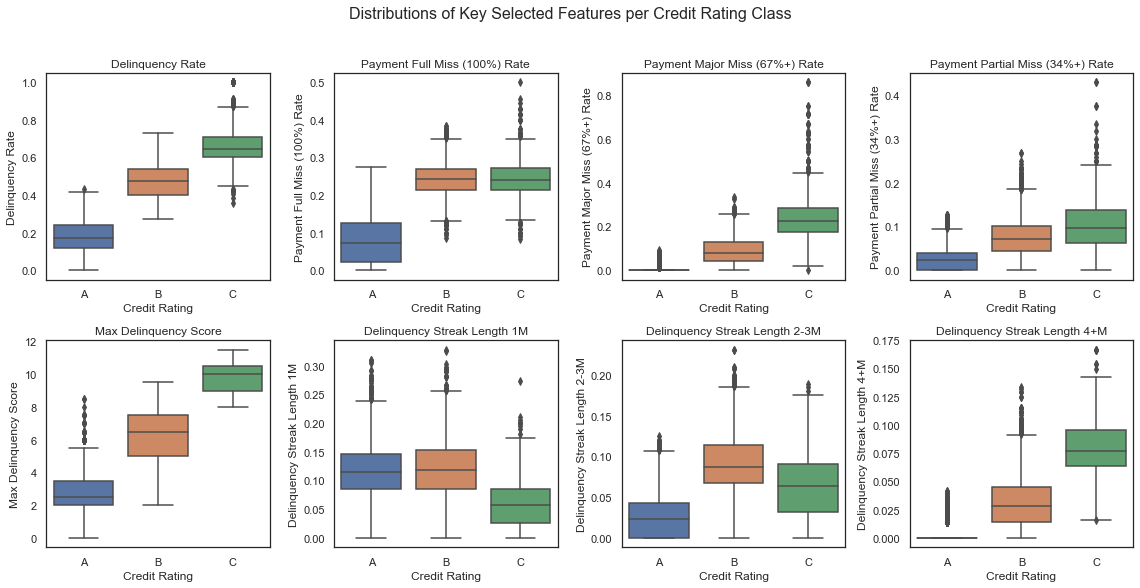

In [11]:
def plot_feature_distributions_by_class(df, feature_columns, class_column):
    """
    Boxplot the distribution of each feature by class.
    """
    df = df.copy()
    df[class_column] = pd.Categorical(
        df[class_column],
        categories=sorted(df[class_column].unique()),
        ordered=True
    )
    num_features = len(feature_columns)
    cols = 4
    rows = (num_features + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows), constrained_layout=True)
    axes = axes.flatten()
    for i, feature in enumerate(feature_columns):
        ax = axes[i]
        sns.boxplot(
            data=df,
            x=class_column,
            y=feature,
            ax=ax,
            palette="deep",
            hue_order=sorted(df[class_column].unique()),
            order=sorted(df[class_column].unique()),
        )
        ax.set_title(f"{feature}")
        ax.set_xlabel(class_column)
        ax.set_ylabel(feature)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()

features_names_dict = {
    'total_delinquencies_norm': 'Delinquency Rate',
    'count_full_misses_norm': 'Payment Full Miss (100%) Rate',
    'count_major_misses_norm': 'Payment Major Miss (67%+) Rate',
    'count_partial_misses_norm': 'Payment Partial Miss (34%+) Rate',
    'max_delinquency_score': 'Max Delinquency Score',
    'count_streak_1_norm': 'Delinquency Streak Length 1M',
    'count_streak_2_3_norm': 'Delinquency Streak Length 2-3M',
    'count_streak_4plus_norm': 'Delinquency Streak Length 4+M',
    # 'count_minor_misses_norm':  'Payment Minor Miss Rate',
}


plot_feature_distributions_by_class(
    df = final_snapshots_combined.rename(columns=features_names_dict).rename(columns={'label': 'Credit Rating'}),
    feature_columns = list(features_names_dict.values()),
    class_column = "Credit Rating"
)
plt.tight_layout(pad=3)
plt.suptitle("Distributions of Key Selected Features per Credit Rating Class", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## **5. Modeling Approach and Training**

### **Training Snapshots**

Our dataset contains thousands of monthly snapshots, but not all are useful for training. To create a learning environment that mirrors how the model would be used in practice, we applied careful sampling criteria:

- ✅ **Closed Accounts**: We included all snapshots—these show clear high-risk behavior across the lifecycle.  
- ✅ **Mature Active Accounts**: Only those with at least 24 months of history, to ensure sufficient behavioral context.  
- ✅ **Timing Filter**: Snapshots must be taken at least 6 months into the account lifecycle, to avoid noise from early instability.  
- 🔁 **Temporal Spacing**: We sampled one snapshot every 3 months (e.g., Month 6, 9, 12…), to reduce redundancy.  
- ❌ **Excluding Final Snapshots**: Final records often include outcome clues. We removed them to avoid leakage.

The dataset was split into **training and validation sets** with no overlapping accounts, ensuring that model evaluation was not biased by prior exposure to the same account history.

### **Model Selection**

We used a **Random Forest Classifier**—a tree-based model well-suited for structured behavioral data and easy to interpret.


In [12]:
train_split = balance_snapshots_metadata[balance_snapshots_metadata['purpose'] == 'train'].index
test_split = balance_snapshots_metadata[balance_snapshots_metadata['purpose'] == 'test'].index

train_features = balance_snapshots_features.loc[train_split]
test_features = balance_snapshots_features.loc[test_split]

train_labels = balance_snapshots_metadata.loc[train_split, 'label']
test_labels = balance_snapshots_metadata.loc[test_split, 'label']

print("Train Labels counts:", train_labels.value_counts().to_dict())
print("Test Labels counts:", test_labels.value_counts().to_dict())

Train Labels counts: {'A': 59338, 'B': 47655, 'C': 7446}
Test Labels counts: {'A': 12915, 'B': 10036, 'C': 1475}


In [13]:
# Try undersampling the majority class
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score
# Apply Random Under Sampling to the training data

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_features)
X_test_scaled = scaler.transform(test_features)

rus = RandomUnderSampler(random_state=42 ,replacement=True)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, train_labels)

# # Train and evaluate classifier on resampled data
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_resampled, y_train_resampled)
y_pred = model_rf.predict(X_test_scaled)

print('f1_score:', f1_score(test_labels, y_pred, average='weighted'))
print('balanced_accuracy_score:', balanced_accuracy_score(test_labels, y_pred))

f1_score: 0.8413298863011227
balanced_accuracy_score: 0.811804816601236


## **6. Model Evaluation and Interpretation**

Once trained, we evaluated the model not just on statistical metrics—but on its ability to support real decisions. Evaluation focused on three core questions:

- **Class-wise Performance**: How well does the model distinguish between low, medium, and high-risk accounts?  
- **Snapshot Age Impact**: How early can the model make reliable predictions?  
- **Confidence Calibration**: Do higher-confidence predictions lead to better accuracy?

### **Class-wise Performance: Confusion Matrix**

The confusion matrices below show the model’s class-wise performance in terms of count, recall, and precision:

- ✅ **Low Risk (A)**: High recall (**93%**) and precision (**93%**)—very few false positives or negatives  
- ⚠️ **Medium Risk (B)**: Moderate recall (**71%**) and strong precision (**86%**)—captures many but not all borderline cases  
- ✅ **High Risk (C)**: Good recall (**80%**) but lower precision (**36%**)—model flags risky accounts well but sometimes confuses them with borderline B cases  

This reflects the inherent ambiguity in Class B and partial overlap with Class C.

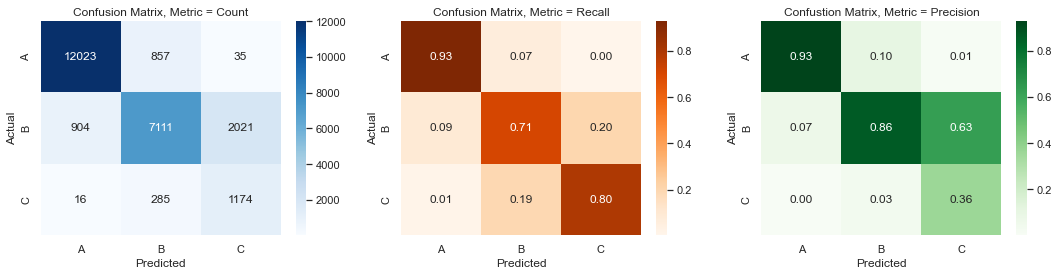

In [14]:
from sklearn.metrics import confusion_matrix

y_true = test_labels
y_pred = y_pred
class_labels = ['A', 'B', 'C'] 
conf_matrix = confusion_matrix(y_true, y_pred)
normalized_conf_matrix_true = confusion_matrix(y_true, y_pred, normalize='true')
normalized_conf_matrix_pred = confusion_matrix(y_true, y_pred, normalize='pred')

if class_labels is None:
    class_labels = sorted(set(y_true) | set(y_pred))

plt.figure(figsize=(15, 4))
# Plot confusion matrix
plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix, Metric = Count")
# Plot normalized confusion matrix (true)
plt.subplot(1, 3, 2)
sns.heatmap(normalized_conf_matrix_true, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix, Metric = Recall")

plt.subplot(1, 3, 3)
sns.heatmap(normalized_conf_matrix_pred, annot=True, fmt='.2f', cmap ='Greens',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confustion Matrix, Metric = Precision")
plt.tight_layout()
plt.show()


### **Snapshot Age: Performance Improves Over Time**

As account age increases, performance improves across all metrics:

- **Precision**: Increases steadily, especially for Classes A and B  
- **Recall**: Strong early on for Class A; improves for B and C as more history accumulates  
- **F1 Score**: Rises consistently with age—showing that the model benefits from behavioral depth  

By **24–36 months**, the model achieves high balance across precision, recall, and F1 for all classes.


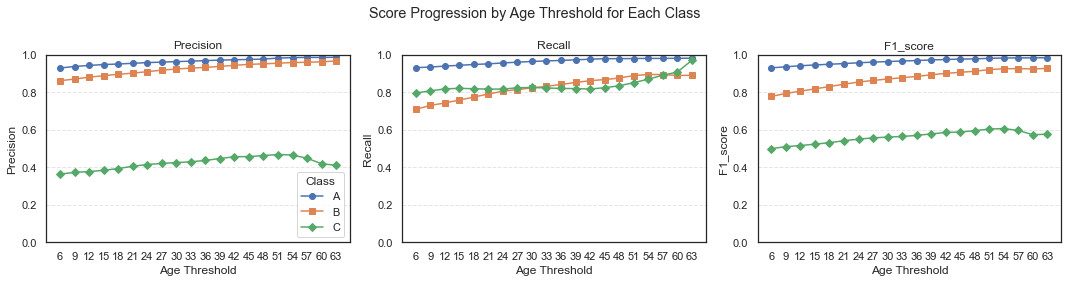

In [15]:
# Add this before or after your plotting code
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

test_labels_df = pd.DataFrame({
    'check_cycle_number': test_features['check_cycle_number'],
    'true_label': test_labels,
    'pred_label': y_pred,
})

age_thresholds = np.arange(6, 66,3)  # Example age thresholds: 0, 12, 24, ..., 72
metrics_per_age = []

for age in age_thresholds:
    filt = test_labels_df['check_cycle_number'] >= age
    y_true = test_labels_df[filt]['true_label']
    y_pred_age = test_labels_df[filt]['pred_label']

    # Compute metrics per class
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred_age, zero_division=0
    )
    # acc = accuracy_score(y_true, y_pred_age)
    for i, class_name in enumerate(['A', 'B', 'C']):
        metrics_per_age.append({
            'age_threshold': age,
            'class': class_name,
            'precision': precision[i],
            'recall': recall[i],
            'f1_score': f1[i],
            'support': support[i],
        })

metrics_df = pd.DataFrame(metrics_per_age)
# display(metrics_df)

# Ensure metrics_df exists from previous cell
score_types = ['precision', 'recall', 'f1_score']
class_names = metrics_df['class'].unique()
age_thresholds = sorted(metrics_df['age_threshold'].unique())

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
for idx, score in enumerate(score_types):
    ax = axes[idx]
    for j,class_name in enumerate(class_names):
        class_scores = metrics_df[metrics_df['class'] == class_name].sort_values('age_threshold')
        ax.plot(class_scores['age_threshold'], class_scores[score], marker=['o', 's', 'D'][j], label=class_name)
    ax.set_title(score.capitalize())
    ax.set_xlabel('Age Threshold')
    ax.set_ylabel(score.capitalize())
    ax.set_xticks(age_thresholds)
    ax.set_ylim(0, 1) if score != 'support' else ax.set_ylim(0, metrics_df['support'].max() + 10)
    if idx == 0:
        ax.legend(title='Class')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.suptitle('Score Progression by Age Threshold for Each Class')
plt.tight_layout()
plt.show()

### **Prediction Confidence: Accuracy Scales with Certainty**

For each prediction, the model outputs class probabilities—allowing us to assess both label and confidence. When grouped by minimum confidence levels:

- Predictions with **≥0.9 confidence** are highly accurate:  
  - ~**98–100%** for A and B ratings  
  - ~**87–90%** for C ratings at higher age thresholds  

Accuracy scales with both **confidence and account age**—validating the model’s reliability under stricter thresholds.

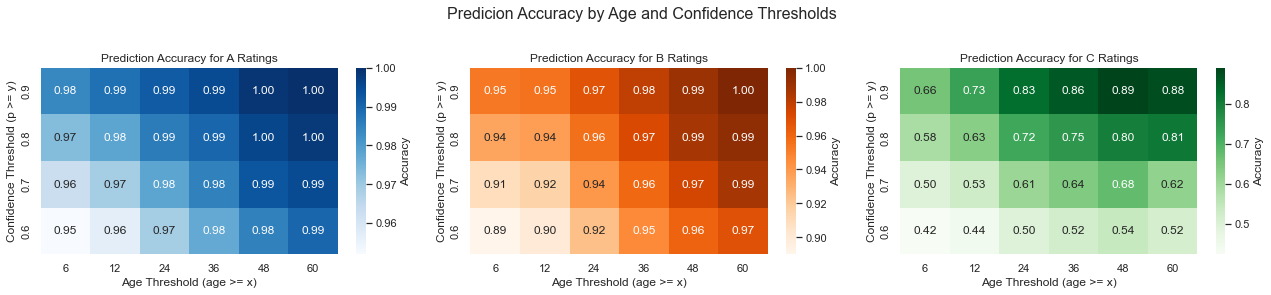

In [16]:
labels = ['A', 'B', 'C']
thresholds = [0.6, 0.7, 0.8, 0.9]
age_thresholds = [6] + list(range(12, test_labels_df['check_cycle_number'].max() + 1, 12))
index = pd.MultiIndex.from_product([labels, thresholds], names=['threshold', 'label'])
df_accuracy_per_threshold = []

test_labels_proba = pd.DataFrame(model_rf.predict_proba(X_test_scaled),
                                  columns=[f'P[{c}]' for c in model_rf.classes_], 
                                  index=test_features.index)
test_labels_df = pd.concat([test_labels_df, test_labels_proba], axis=1)

# Check to see how many predictions are correct at each threshold, save in a dataframe
for label_num, label in enumerate(['A', 'B', 'C']):
    for threshold in thresholds:
        for age_threshold in age_thresholds:
            df_prob_over_threshold = test_labels_df[(test_labels_df[f'P[{label}]'] >= threshold) & 
                                                        (test_labels_df['check_cycle_number'] >= age_threshold)]
            correct_predictions = df_prob_over_threshold[df_prob_over_threshold['true_label'] == df_prob_over_threshold['pred_label']]
            num_predictions = len(df_prob_over_threshold)
            num_correct_predictions = len(correct_predictions)
            accuracy = np.round(num_correct_predictions / num_predictions, 3) if num_predictions > 0 else 0
            error_rate = np.round(1 - accuracy, 3) if num_predictions > 0 else 0
            df_accuracy_per_threshold.append({
                'label': label,
                'threshold': threshold,
                'age_threshold': age_threshold,
                'num_predictions': num_predictions,
                'correct_predictions': num_correct_predictions,
                'accuracy': accuracy,
                'error_rate': error_rate
            })
df_accuracy_per_threshold = pd.DataFrame(df_accuracy_per_threshold)
df_accuracy_per_threshold_pivoted = df_accuracy_per_threshold.pivot_table(
        index='age_threshold', 
        columns=['label', 'threshold'], 
        values='accuracy'
).T.sort_index(ascending=False)
df_accuracy_per_threshold_support_pivoted = df_accuracy_per_threshold.pivot_table(
        index='age_threshold', 
        columns=['label', 'threshold'], 
        values='num_predictions'
).T.sort_index(ascending=False)

plt.figure(figsize=(18, 4))
for i, label in enumerate(['A', 'B', 'C']):
    plt.subplot(1, 3, i + 1)
    sns.heatmap(
        df_accuracy_per_threshold_pivoted.loc[label],
        annot=True, fmt='.2f', cmap={0:'Blues', 1: 'Oranges', 2: 'Greens'}[i],
        cbar_kws={'label': 'Accuracy'}
    )
    plt.xlabel('Age Threshold (age >= x)')
    plt.ylabel('Confidence Threshold (p >= y)')
    plt.title(f"Prediction Accuracy for {label} Ratings")

plt.suptitle("Predicion Accuracy by Age and Confidence Thresholds", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## **7. Explainability: Opening the Black Box**

For our risk model to be usable in operations, **transparency is essential**. It’s not enough to predict risk—we need to show *why* an account was flagged. To support this, we added two layers of explainability: **global** and **local**.

### **Global Feature Importance: What the Model Prioritizes**

We used **SHAP values** to measure the average impact of each feature across all predictions.

📌 **Top Predictive Features Included**:

- **Total Penalty Points**  
- **Delinquency Rate**  
- **Payment Major Miss Rate**  
- **Suspension Rate**  
- **Payment Full Miss Rate**  

These features clearly align with business intuition—accounts with frequent penalties, suspensions, and missed payments are more likely to be high-risk. The model's priorities confirm that it learned meaningful, interpretable signals.

 99%|===================| 2980/3000 [02:16<00:00]        

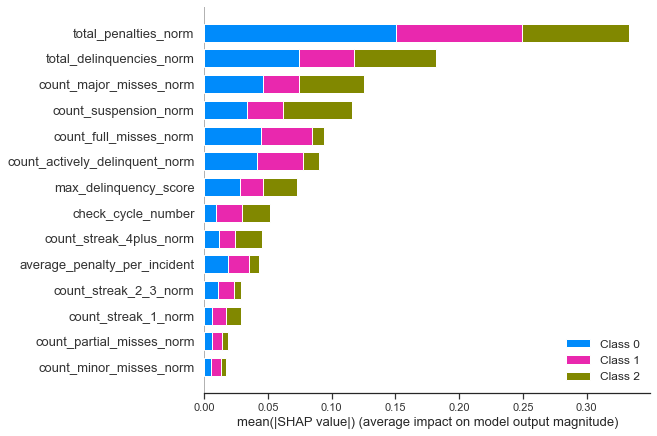

In [17]:
import shap

def get_shap_values(model, background, X_to_explain):
    explainer = shap.TreeExplainer(model, data=background)
    shap_values = explainer.shap_values(X_to_explain, check_additivity=False)
    return shap_values


X_to_explain = pd.DataFrame(X_test_scaled,columns=test_features.columns).sample(1000, random_state=42)
shap_values = get_shap_values(model = model_rf, 
                background = pd.DataFrame(X_train_resampled, 
                              columns=train_features.columns),  
                X_to_explain = X_to_explain
)

shap.summary_plot(shap_values, X_to_explain, plot_type='bar')


### **Local Explanations: Why Each Account Was Rated That Way**

For individual predictions, we used SHAP to break down the contribution of each feature.

To illustrate, let’s look at **Snapshot ID: 305692**, which was classified as **Class C (High Risk)**.

**Three key features drove this outcome**:

- **`count_suspension_norm = 0.17` → SHAP +0.09**  
  Frequent service suspensions strongly signaled instability and contributed heavily to the high-risk rating.

- **`total_penalties_norm = 0.88` → SHAP +0.08**  
  The account accumulated significant penalties, reinforcing the pattern of non-compliance.

- **`total_delinquencies_norm = 0.58` → SHAP +0.07**  
  Repeated delinquency incidents further elevated the likelihood of default.

Each of these behaviors promoted the model’s confidence in assigning a high-risk label. By breaking down the prediction into feature-level impacts, analysts gain **clear visibility** into *why* the account was flagged—enabling **informed, traceable decision-making**.

In [18]:
snapshot_ids = [305692] # Other examples: 402670,310642,
X_original = test_features.loc[snapshot_ids]
X_to_explain = pd.DataFrame(X_test_scaled,columns=test_features.columns, index=test_features.index).loc[snapshot_ids]
shap_values = get_shap_values(model = model_rf, 
                background = pd.DataFrame(X_train_resampled, 
                              columns=train_features.columns),  
                X_to_explain = X_to_explain
)
pred_classes = model_rf.predict(X_to_explain)
pred_classes_idices = np.array([model_rf.classes_.tolist().index(c) for c in pred_classes])
prediction_explained_example = []
for snapshot_id, shap_val, class_idx in zip(snapshot_ids, shap_values, pred_classes_idices):
    pred_shap = sorted(zip(test_features.columns, shap_val[:,class_idx]), key=lambda x: abs(x[1]), reverse=True)[:5]
    pred_shap_df = pd.DataFrame(pred_shap, columns=['feature', 'shap_value'])
    pred_shap_df['feature_rank'] = range(1, len(pred_shap_df) + 1)
    pred_shap_df['effect'] = np.where(pred_shap_df['shap_value'] > 0, 'Promote Likelihood', 'Demote Likelihood')
    pred_shap_df['snapshot_id'] = snapshot_id
    pred_shap_df['feature_value'] = X_original.loc[snapshot_id,pred_shap_df['feature'].values].values
    pred_shap_df['predicted_class'] = model_rf.classes_[class_idx]
    prediction_explained_example.append(pred_shap_df)

prediction_explained_example = pd.concat(prediction_explained_example, ignore_index=True).set_index('snapshot_id', drop=True)
prediction_explained_example

,feature,shap_value,feature_rank,effect,feature_value,predicted_class
snapshot_id,,,,,,
305692,check_cycle_number,-0.007343,1,Demote Likelihood,12.0,C



## **8. Case Studies: Risk Classes in Action**

To see how the model behaves in practice, let’s walk through an example from each risk class. These case studies illustrate how behavioral signals, risk probabilities, and model confidence evolve over time.


In [19]:
all_snapshots_predictions = pd.read_csv(os.path.join(MODEL_OUTPUT_DIR, "balance_snapshots_predictions.csv")).set_index('snapshot_id', drop=False)
all_snapshots_predictions_annotated = pd.concat([
    balance_snapshots_metadata,
    all_snapshots_predictions], axis=1
).dropna()
# all_snapshots_predictions_annotated.head().loc[:,'label':]



### 🟩 **Account A – Low Risk**

- **Status:** Active  
- **Account Duration:** 70 months  
- **Delinquency History:** Intermittent, low-severity delinquency events with full resolution; no suspensions or closures  
- **Prediction Pattern:** Consistently predicted as Class A, with probability ≥85% for most of the account’s life  

**What the Model Saw:**

- Short-lived delinquencies quickly recovered  
- Delinquency score stayed well below suspension and closure thresholds  
- No escalations, even during occasional spikes in owed amount  

**Interpretation:**  
This is a resilient, stable account. While there were some isolated issues, they were low in intensity and never escalated. The model correctly identified this as a reliable customer—not in need of intervention.


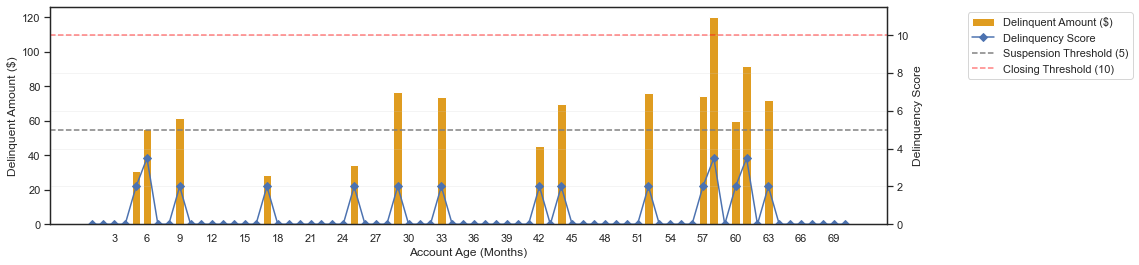

In [20]:
account_key = 100761
sample_account_id = accounts[accounts['account_key'] == account_key].iloc[0]['account_id']
account_balance_snapshots = balance_snapshots[balance_snapshots['account_id'] == sample_account_id].sort_values(by="check_date", ascending=True)
account_balance_snapshots['account_age'] = range(1, len(account_balance_snapshots) + 1)
plt.figure(figsize=(15,4))
plot_account_snapshots_balance_and_delinquency(account_balance_snapshots)
plt.show()


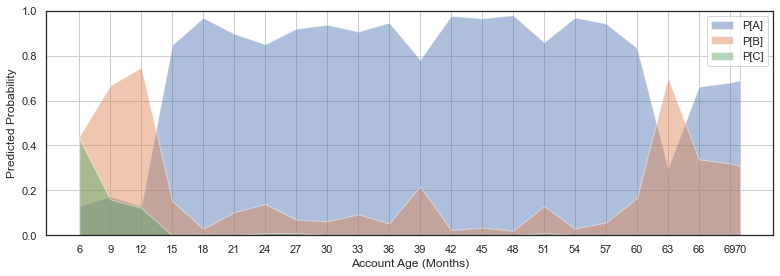

In [21]:
account_balance_snapshots_predictions = all_snapshots_predictions_annotated[
    (all_snapshots_predictions_annotated['account_id'] == sample_account_id) & 
    (all_snapshots_predictions_annotated['is_final_snapshot'] | all_snapshots_predictions_annotated['is_live_snapshot'])
    ].sort_values(by="check_date", ascending=True)
account_balance_snapshots_predictions

plt.figure(figsize=(11,4))
account_data = account_balance_snapshots_predictions

# plt.figure(figsize=(10, 5))
for label in ['A','B','C']:
    plt.fill_between(account_data['check_cycle_number'], 
                        0, 
                        account_data[f'P[{label}]'], 
                        label=f'P[{label}]', alpha=0.45)

# plt.title(f'Stacked Predicted Probabilities for Account ID {account_id}')
plt.xlabel('Account Age (Months)')
plt.ylabel('Predicted Probability')
plt.xticks(account_data['check_cycle_number'])
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### 🟧 **Account B – Medium Risk**

- **Status:** Active  
- **Account Duration:** 70 months  
- **Delinquency History:** Frequent delinquency events throughout the account’s life—often moderate to high in dollar amount. While the account avoided closure, it repeatedly approached the suspension threshold, signaling recurring financial strain.  
- **Prediction Pattern:** The model steadily predicted Class B for most of the account’s lifecycle, with probability rising above 85% from around month 24 onward. Class C briefly emerged early, but never dominated, and Class A faded quickly as risk signs accumulated.

**What the Model Saw:**

- Repeated missed or late payments, often leading to sharp spikes in delinquency score  
- Several sustained penalty cycles, but not enough to trigger account closure  
- A pattern of unstable behavior: problems weren’t isolated, but also didn’t fully escalate  

**Interpretation:**  
This is a watchlist-type account. It’s not a clear default, but the pattern of repeated delinquency signals real concern. The model’s classification reflects this uncertainty, placing the account firmly in the “at-risk but recoverable” category.


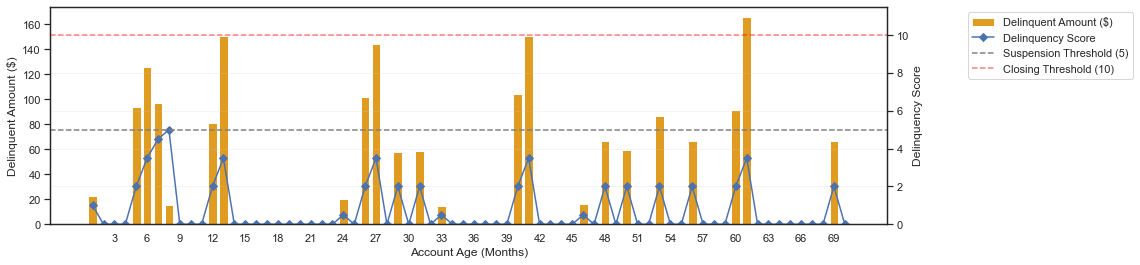

In [22]:
account_key = 100039
sample_account_id = accounts[accounts['account_key'] == account_key].iloc[0]['account_id']
account_balance_snapshots = balance_snapshots[balance_snapshots['account_id'] == sample_account_id].sort_values(by="check_date", ascending=True)
account_balance_snapshots['account_age'] = range(1, len(account_balance_snapshots) + 1)
plt.figure(figsize=(15,4))
plot_account_snapshots_balance_and_delinquency(account_balance_snapshots)
plt.show()


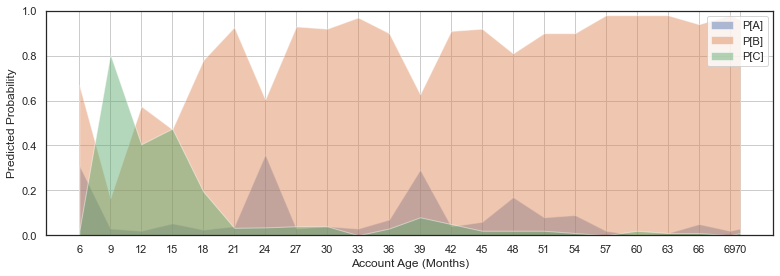

In [23]:
account_balance_snapshots_predictions = all_snapshots_predictions_annotated[
    (all_snapshots_predictions_annotated['account_id'] == sample_account_id) & 
    (all_snapshots_predictions_annotated['is_final_snapshot'] | all_snapshots_predictions_annotated['is_live_snapshot'])
    ].sort_values(by="check_date", ascending=True)
account_balance_snapshots_predictions

plt.figure(figsize=(11,4))
account_data = account_balance_snapshots_predictions

# plt.figure(figsize=(10, 5))
for label in ['A','B','C']:
    plt.fill_between(account_data['check_cycle_number'], 
                        0, 
                        account_data[f'P[{label}]'], 
                        label=f'P[{label}]', alpha=0.45)

# plt.title(f'Stacked Predicted Probabilities for Account ID {account_id}')
plt.xlabel('Account Age (Months)')
plt.ylabel('Predicted Probability')
plt.xticks(account_data['check_cycle_number'])
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### 🟥 **Account C – High Risk**

- **Status:** Closed  
- **Account Duration:** 46 months  
- **Delinquency History:** Persistent payment failures with multiple escalations—account crossed suspension thresholds repeatedly and eventually closed  
- **Prediction Pattern:** High confidence in Class C throughout—probability >80% in most months after early signs of deterioration  

**What the Model Saw:**

- 📈 Delinquency score steadily climbed, eventually breaching the closing threshold  
- 🔁 Long and repeated streaks of missed payments  
- 🚨 High penalty accumulation, no sustained recovery  

**Interpretation:**  
A clear high-risk case with structural payment issues and no lasting improvement. The model accurately identified the risk buildup and consistently flagged the account for intervention—well before closure.

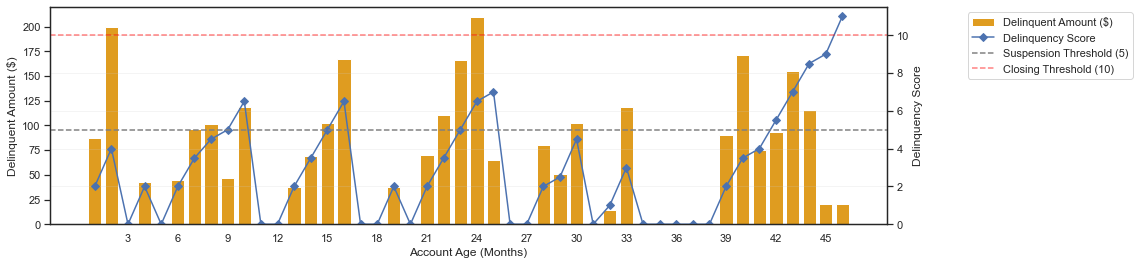

In [24]:
account_key = 102619
sample_account_id = accounts[accounts['account_key'] == account_key].iloc[0]['account_id']
account_balance_snapshots = balance_snapshots[balance_snapshots['account_id'] == sample_account_id].sort_values(by="check_date", ascending=True)
account_balance_snapshots['account_age'] = range(1, len(account_balance_snapshots) + 1)
plt.figure(figsize=(15,4))
plot_account_snapshots_balance_and_delinquency(account_balance_snapshots)
plt.show()


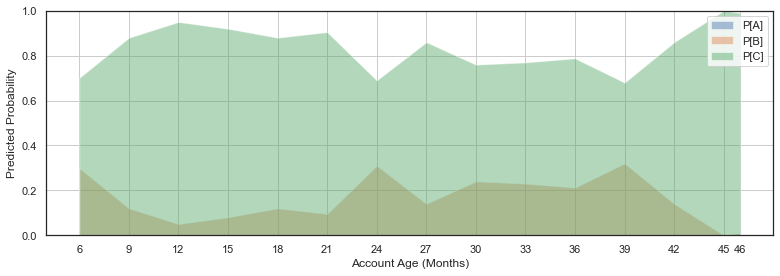

In [25]:
account_balance_snapshots_predictions = all_snapshots_predictions_annotated[
    (all_snapshots_predictions_annotated['account_id'] == sample_account_id) & 
    (all_snapshots_predictions_annotated['is_final_snapshot'] | all_snapshots_predictions_annotated['is_live_snapshot'])
    ].sort_values(by="check_date", ascending=True)
account_balance_snapshots_predictions

plt.figure(figsize=(11,4))
account_data = account_balance_snapshots_predictions

# plt.figure(figsize=(10, 5))
for label in ['A','B','C']:
    plt.fill_between(account_data['check_cycle_number'], 
                        0, 
                        account_data[f'P[{label}]'], 
                        label=f'P[{label}]', alpha=0.45)

# plt.title(f'Stacked Predicted Probabilities for Account ID {account_id}')
plt.xlabel('Account Age (Months)')
plt.ylabel('Predicted Probability')
plt.xticks(account_data['check_cycle_number'])
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## **9. Recap: From Behavior to Risk Classification**

This phase of the project transformed raw billing data into a practical tool for predicting and understanding credit risk. Here’s what we built—and why it matters.

### ✅ **A Full Classification Pipeline**

We developed an end-to-end system that:

- Aggregates monthly billing snapshots into lifecycle-aware features  
- Labels accounts using a hybrid rule and clustering approach (Class A/B/C)  
- Trains a supervised model to predict future risk based on past behavior  
- Outputs class probabilities and explanation-ready predictions  

### 💡 **Features That Capture Behavior Over Time**

We engineered features that track not just what happened, but *how* it happened:

- Missed payment rates and penalty severity  
- Recovery streaks and recent issues  
- Suspension patterns and long-term reliability  

These metrics gave the model the ability to “understand” customer trajectories—critical for early detection.

### 🧠 **Labels That Reflect Business Reality**

Instead of oversimplifying risk as a binary (good vs. bad), we introduced a three-class system:

- **Class A** – Consistently reliable  
- **Class B** – Mixed or unstable  
- **Class C** – High risk, closed or near-closure  

This supports real-world use cases like triaging accounts, focusing collections, and tracking behavior shifts.

### 📊 **Performance That’s Actionable**

- Strong separation between classes in the confusion matrix  
- High-confidence predictions aligned with clean behavioral signals  
- SHAP values that explain why each account is classified the way it is  

Together, these insights make the model not just accurate—but usable by business teams.


## **10. Next Step: Bringing These Predictions to Life**

### 👇 **What’s Next?**

In the final part of this series, we’ll bring everything together inside **Power BI**—showing how risk predictions become interactive dashboards that support daily operations, portfolio oversight, and explainable decision-making.


If you’re interested in how to make machine learning useful—not just accurate—I invite you to explore **Part 3**, where we operationalize this model into a real-time credit risk monitoring tool.


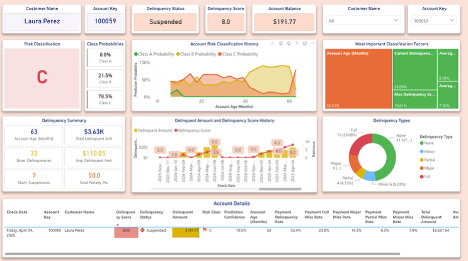

In [26]:
# Render a screenshot
from IPython.display import Image, display

display(Image('data/part3_teaser.png',width=800, height=500))




### 🔄 **Linked Project Series**

This article is the second installment in a three-part series on building a full-cycle credit risk monitoring system for utility accounts. Each part builds on the last—creating a practical pipeline from behavioral simulation to business-ready insight:

- **Part 1 – Data Simulation**  
  We created a synthetic dataset that mirrors real utility billing behavior over time—tracking payments, penalties, suspensions, and closures. This simulation engine formed the foundation for everything that followed.

- **Part 2 – Risk Classification Model (This Article)**  
  We engineered time-aware behavioral features, designed a hybrid labeling strategy, and trained a Random Forest model to classify accounts into risk tiers (A/B/C). We also built in explainability with SHAP values, enabling both predictive power and model transparency.

- **Part 3 – Monitoring Dashboard in Power BI**  
  We turned these predictions into an interactive report that helps business users monitor portfolio-level risk, investigate specific accounts, and understand the behavioral drivers behind each risk score.

### 📌 **Why It Matters**

By combining simulation, modeling, and visualization, this project delivers a complete, explainable risk solution—ready for real-world decision-making. Whether you're an analyst, product owner, or operations lead, the tools and logic presented here offer a replicable framework for data-driven credit risk management.

---

**Got questions, feedback, or ideas for improvement? I’d love to hear from you. Let’s keep building data solutions that make a real impact.**